In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'zebra_finch_theunisson'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [7]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=250,
    mel_upper_edge_hertz=12000,
    butter_lowcut = 250,
    butter_highcut = 12000,
    ref_level_db = 20,
    min_level_db = -65,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [8]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [9]:
dataset.sample_json

OrderedDict([('species', 'Taeniopygia guttata'),
             ('common_name', 'Zebra finch'),
             ('wav_loc',
              '/mnt/cube/Datasets/ZebraFinch/VocalizationBank/ZebraFinchVocalizationBank/AdultVocalizations/BlaBla0506_110302-TetC-12.wav'),
             ('samplerate_hz', 44100),
             ('length_s', 0.09090702947845805),
             ('wav_num', '12'),
             ('vocalization_type', 'Te'),
             ('voc_type_full', 'TetC'),
             ('voc_type_def', 'Tet call'),
             ('age', 'AdultVocalizations'),
             ('datetime', '2011-03-02_00-00-00'),
             ('indvs',
              OrderedDict([('BlaBla0506',
                            OrderedDict([('elements',
                                          OrderedDict([('start_times', [0.0]),
                                                       ('end_times',
                                                        [0.09090702947845805])]))]))]))])

In [10]:
dataset.sample_json['vocalization_type']

'Te'

In [11]:
len(dataset.data_files)

3348

#### Create dataset based upon JSON

In [12]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [13]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="elements",
            dict_features_to_retain = ['vocalization_type'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1858s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1432s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:    7.7s
[Parallel(n_j

[Parallel(n_jobs=-1)]: Done 3301 out of 3348 | elapsed:   12.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3348 out of 3348 | elapsed:   13.0s finished


3348

In [14]:
syllable_df[:3]

start_time  end_time        indv  indvi vocalization_type  \
0         0.0  0.090907  BlaBla0506      0                Te   
0         0.0  0.259569  GreGre2522      0                Wh   
0         0.0  0.063991  GraGra0201      0                Th   

                           key  
0    BlaBla0506_110302-TetC-12  
0      GreGre2522_130417-Wh-01  
0  GraGra0201_110907-ThuckC-38

### get audio for dataset

In [15]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0506s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0506s.) Setting batch_size=46.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0086s.) Setting batch_size=23.
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1014 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.5461s.) Setting batch_size=11.
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1669 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1989 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Do

[Parallel(n_jobs=-1)]: Done 3348 out of 3348 | elapsed:   12.5s finished


3348

In [16]:
syllable_df[:3]

start_time  end_time        indv  indvi vocalization_type  \
0         0.0  0.090907  BlaBla0506      0                Te   
0         0.0  0.259569  GreGre2522      0                Wh   
0         0.0  0.063991  GraGra0201      0                Th   

                           key  \
0    BlaBla0506_110302-TetC-12   
0      GreGre2522_130417-Wh-01   
0  GraGra0201_110907-ThuckC-38   

                                               audio   rate  
0  [-0.00010242089339890763, -0.00057870499781021...  44100  
0  [-4.138217915107379e-06, -1.0298563472850973e-...  44100  
0  [-6.724604112049491e-05, -0.000377366215625527...  44100

In [17]:
syllable_df.indvi.values[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
sylls = syllable_df.audio.values

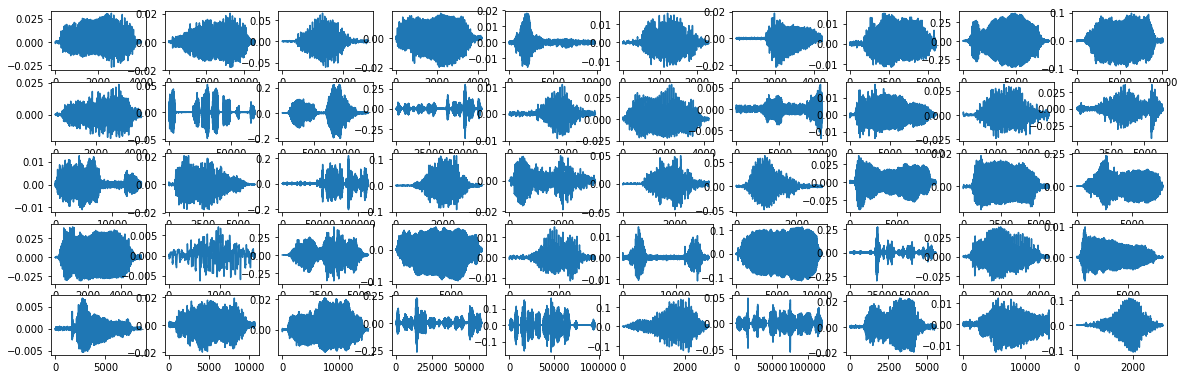

In [19]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms

In [20]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [21]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [22]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0508s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1256s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1026 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1368 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1746 tasks      | elapsed:    1.5s
[Parallel

[Parallel(n_jobs=-1)]: Done 3348 out of 3348 | elapsed:    2.6s finished


### Rescale spectrogram
- using log rescaling

In [23]:
log_scaling_factor = 4

In [24]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0084s.) Setting batch_size=46.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1907s.) Setting batch_size=96.
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    0.2s


[Parallel(n_jobs=-1)]: Done 3348 out of 3348 | elapsed:    0.5s finished


(25.0, 10) (320, 800) 25.0 32 800


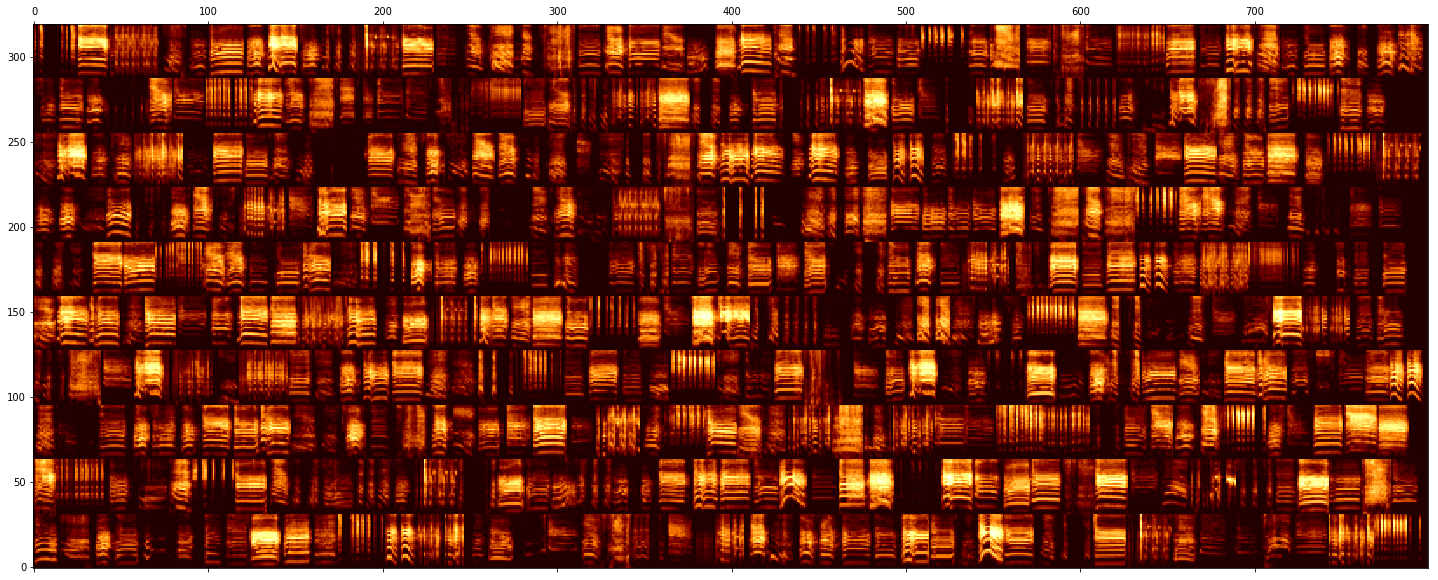

In [25]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [26]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [27]:
syllable_df[:3]

start_time  end_time        indv  indvi vocalization_type  \
0         0.0  0.090907  BlaBla0506      0                Te   
0         0.0  0.259569  GreGre2522      0                Wh   
0         0.0  0.063991  GraGra0201      0                Th   

                           key  \
0    BlaBla0506_110302-TetC-12   
0      GreGre2522_130417-Wh-01   
0  GraGra0201_110907-ThuckC-38   

                                               audio   rate  
0  [-0.00010242089339890763, -0.00057870499781021...  44100  
0  [-4.138217915107379e-06, -1.0298563472850973e-...  44100  
0  [-6.724604112049491e-05, -0.000377366215625527...  44100

In [28]:
import seaborn as sns

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


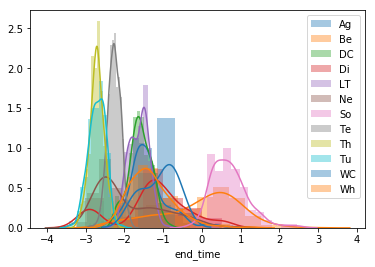

In [29]:
for vocalization_type in np.unique(syllable_df.vocalization_type):
    sns.distplot(np.log(syllable_df[syllable_df.vocalization_type==vocalization_type]["end_time"]), label=vocalization_type)
plt.legend()

In [30]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0125s.) Setting batch_size=30.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0125s.) Setting batch_size=958.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s


[Parallel(n_jobs=-1)]: Done 3348 out of 3348 | elapsed:    0.6s finished


(25.0, 10) (320, 800) 25.0 32 800


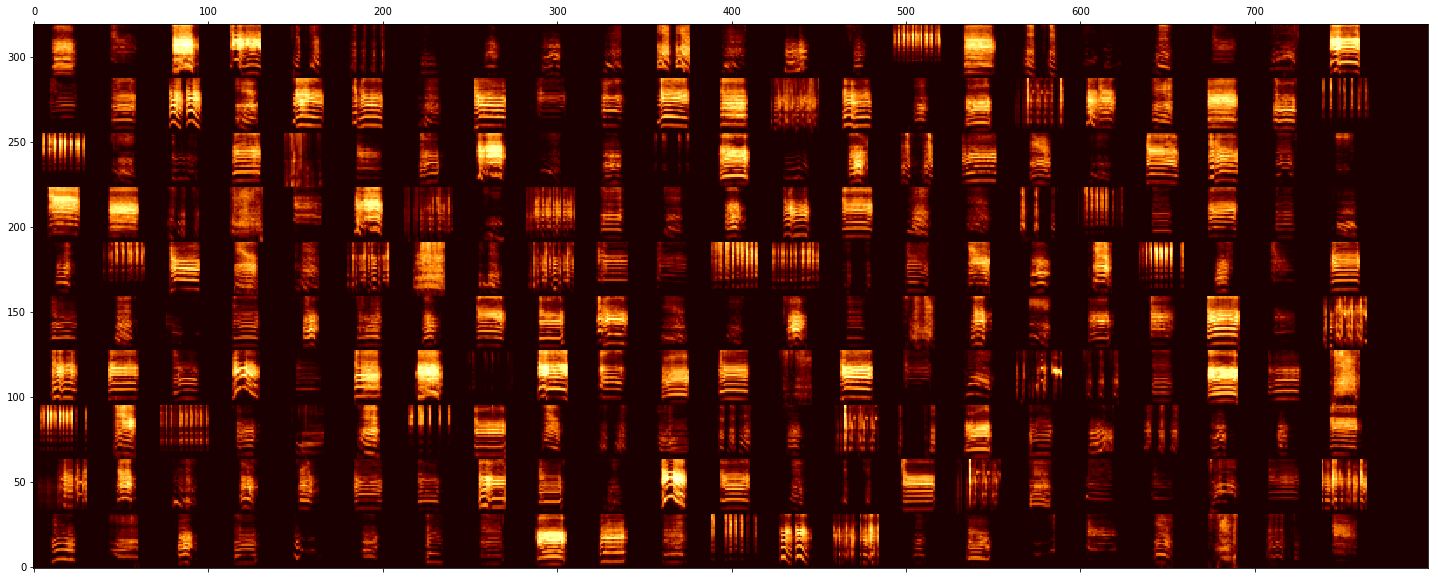

In [31]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [32]:
np.shape(syllables_spec)

(3348, 32, 35)

In [33]:
syllable_df['spectrogram'] = syllables_spec

In [34]:
syllable_df[:3]

start_time  end_time        indv  indvi vocalization_type  \
0         0.0  0.090907  BlaBla0506      0                Te   
0         0.0  0.259569  GreGre2522      0                Wh   
0         0.0  0.063991  GraGra0201      0                Th   

                           key  \
0    BlaBla0506_110302-TetC-12   
0      GreGre2522_130417-Wh-01   
0  GraGra0201_110907-ThuckC-38   

                                               audio   rate  \
0  [-0.00010242089339890763, -0.00057870499781021...  44100   
0  [-4.138217915107379e-06, -1.0298563472850973e-...  44100   
0  [-6.724604112049491e-05, -0.000377366215625527...  44100   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

### view syllables per indv

In [35]:
syllable_df.vocalization_type.unique()

array(['Te', 'Wh', 'Th', 'DC', 'Be', 'So', 'Tu', 'LT', 'Ag', 'Ne', 'Di',
       'WC'], dtype=object)

Ag 196
(50.0, 18) (288, 800) 25.0 32 800


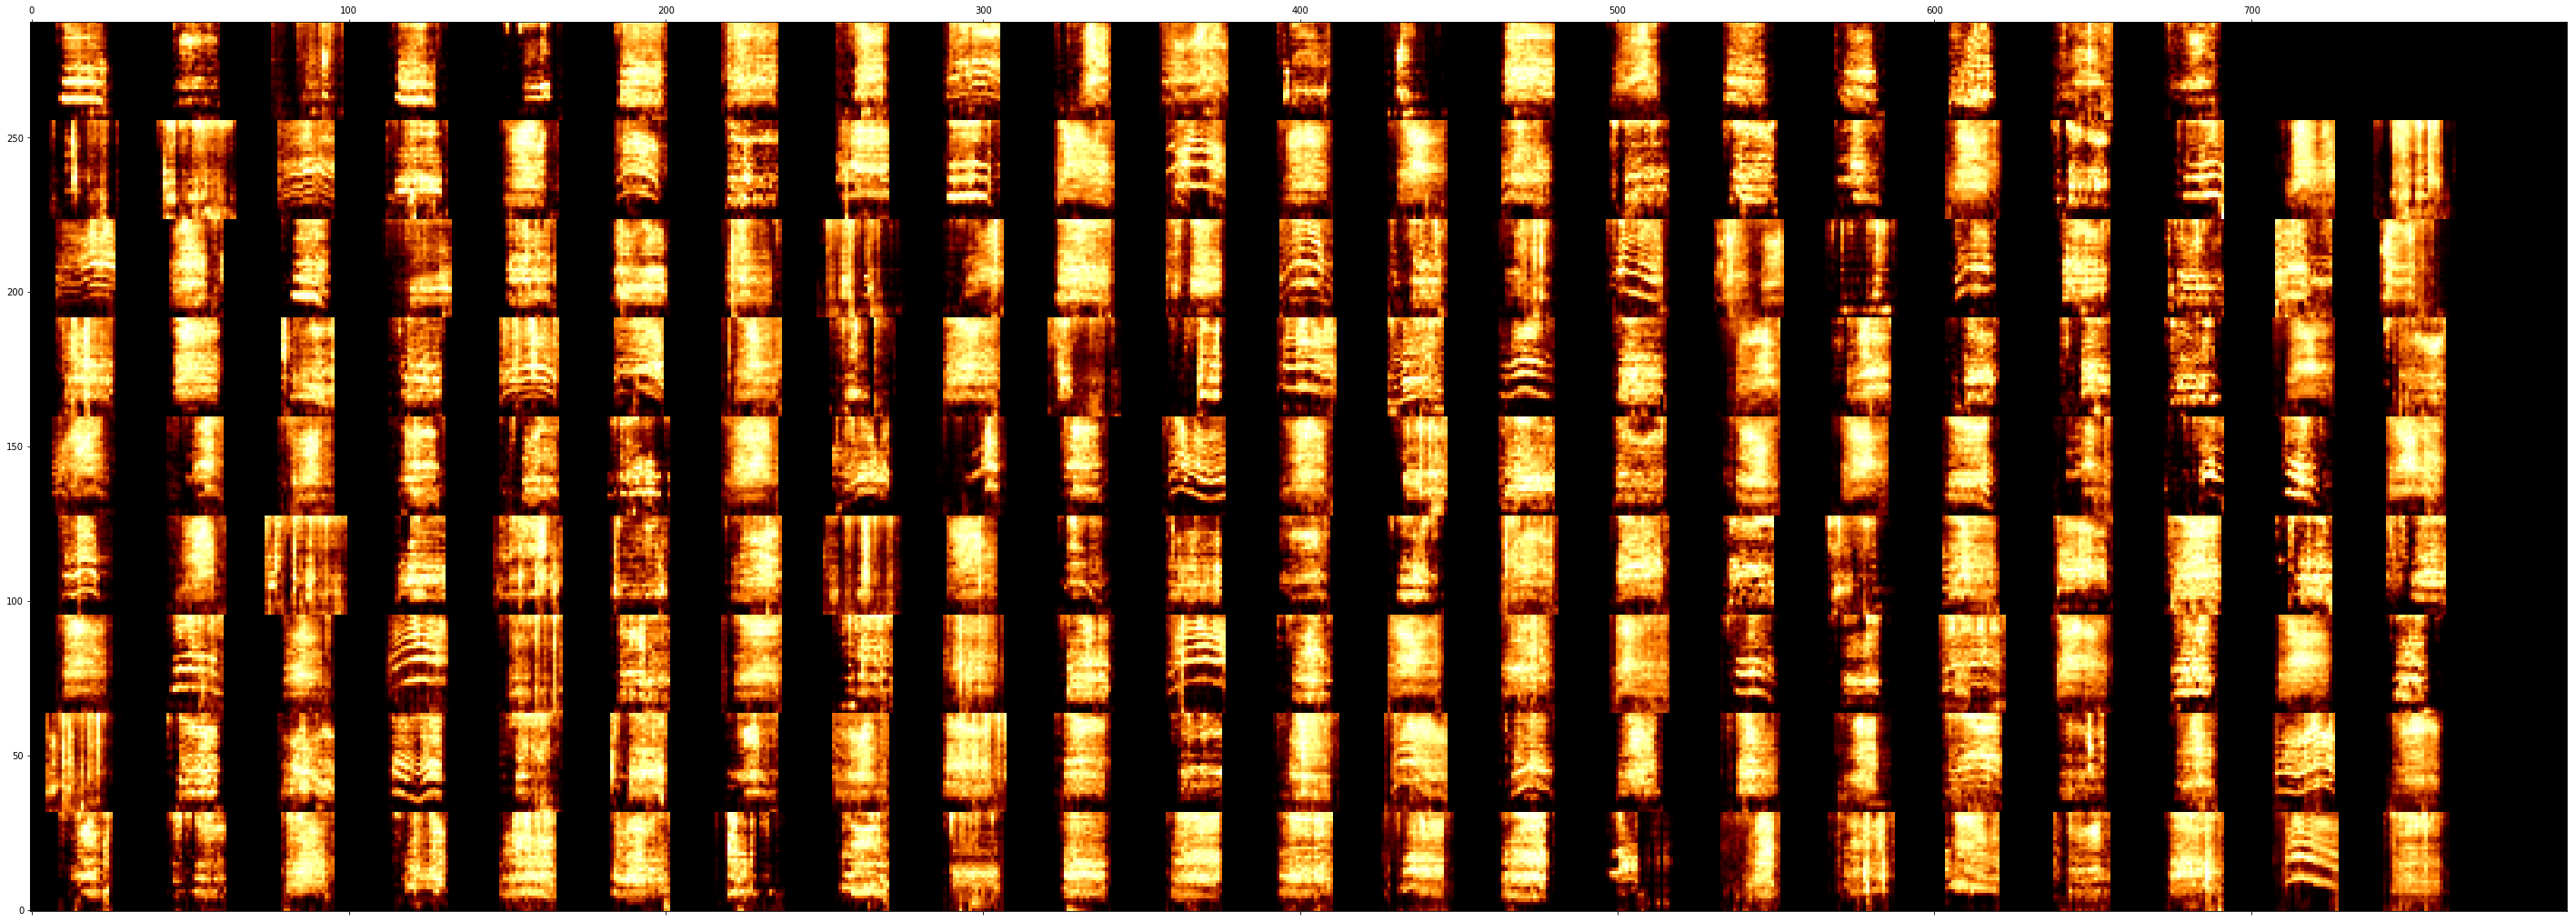

Be 262
(50.0, 24) (384, 800) 25.0 32 800


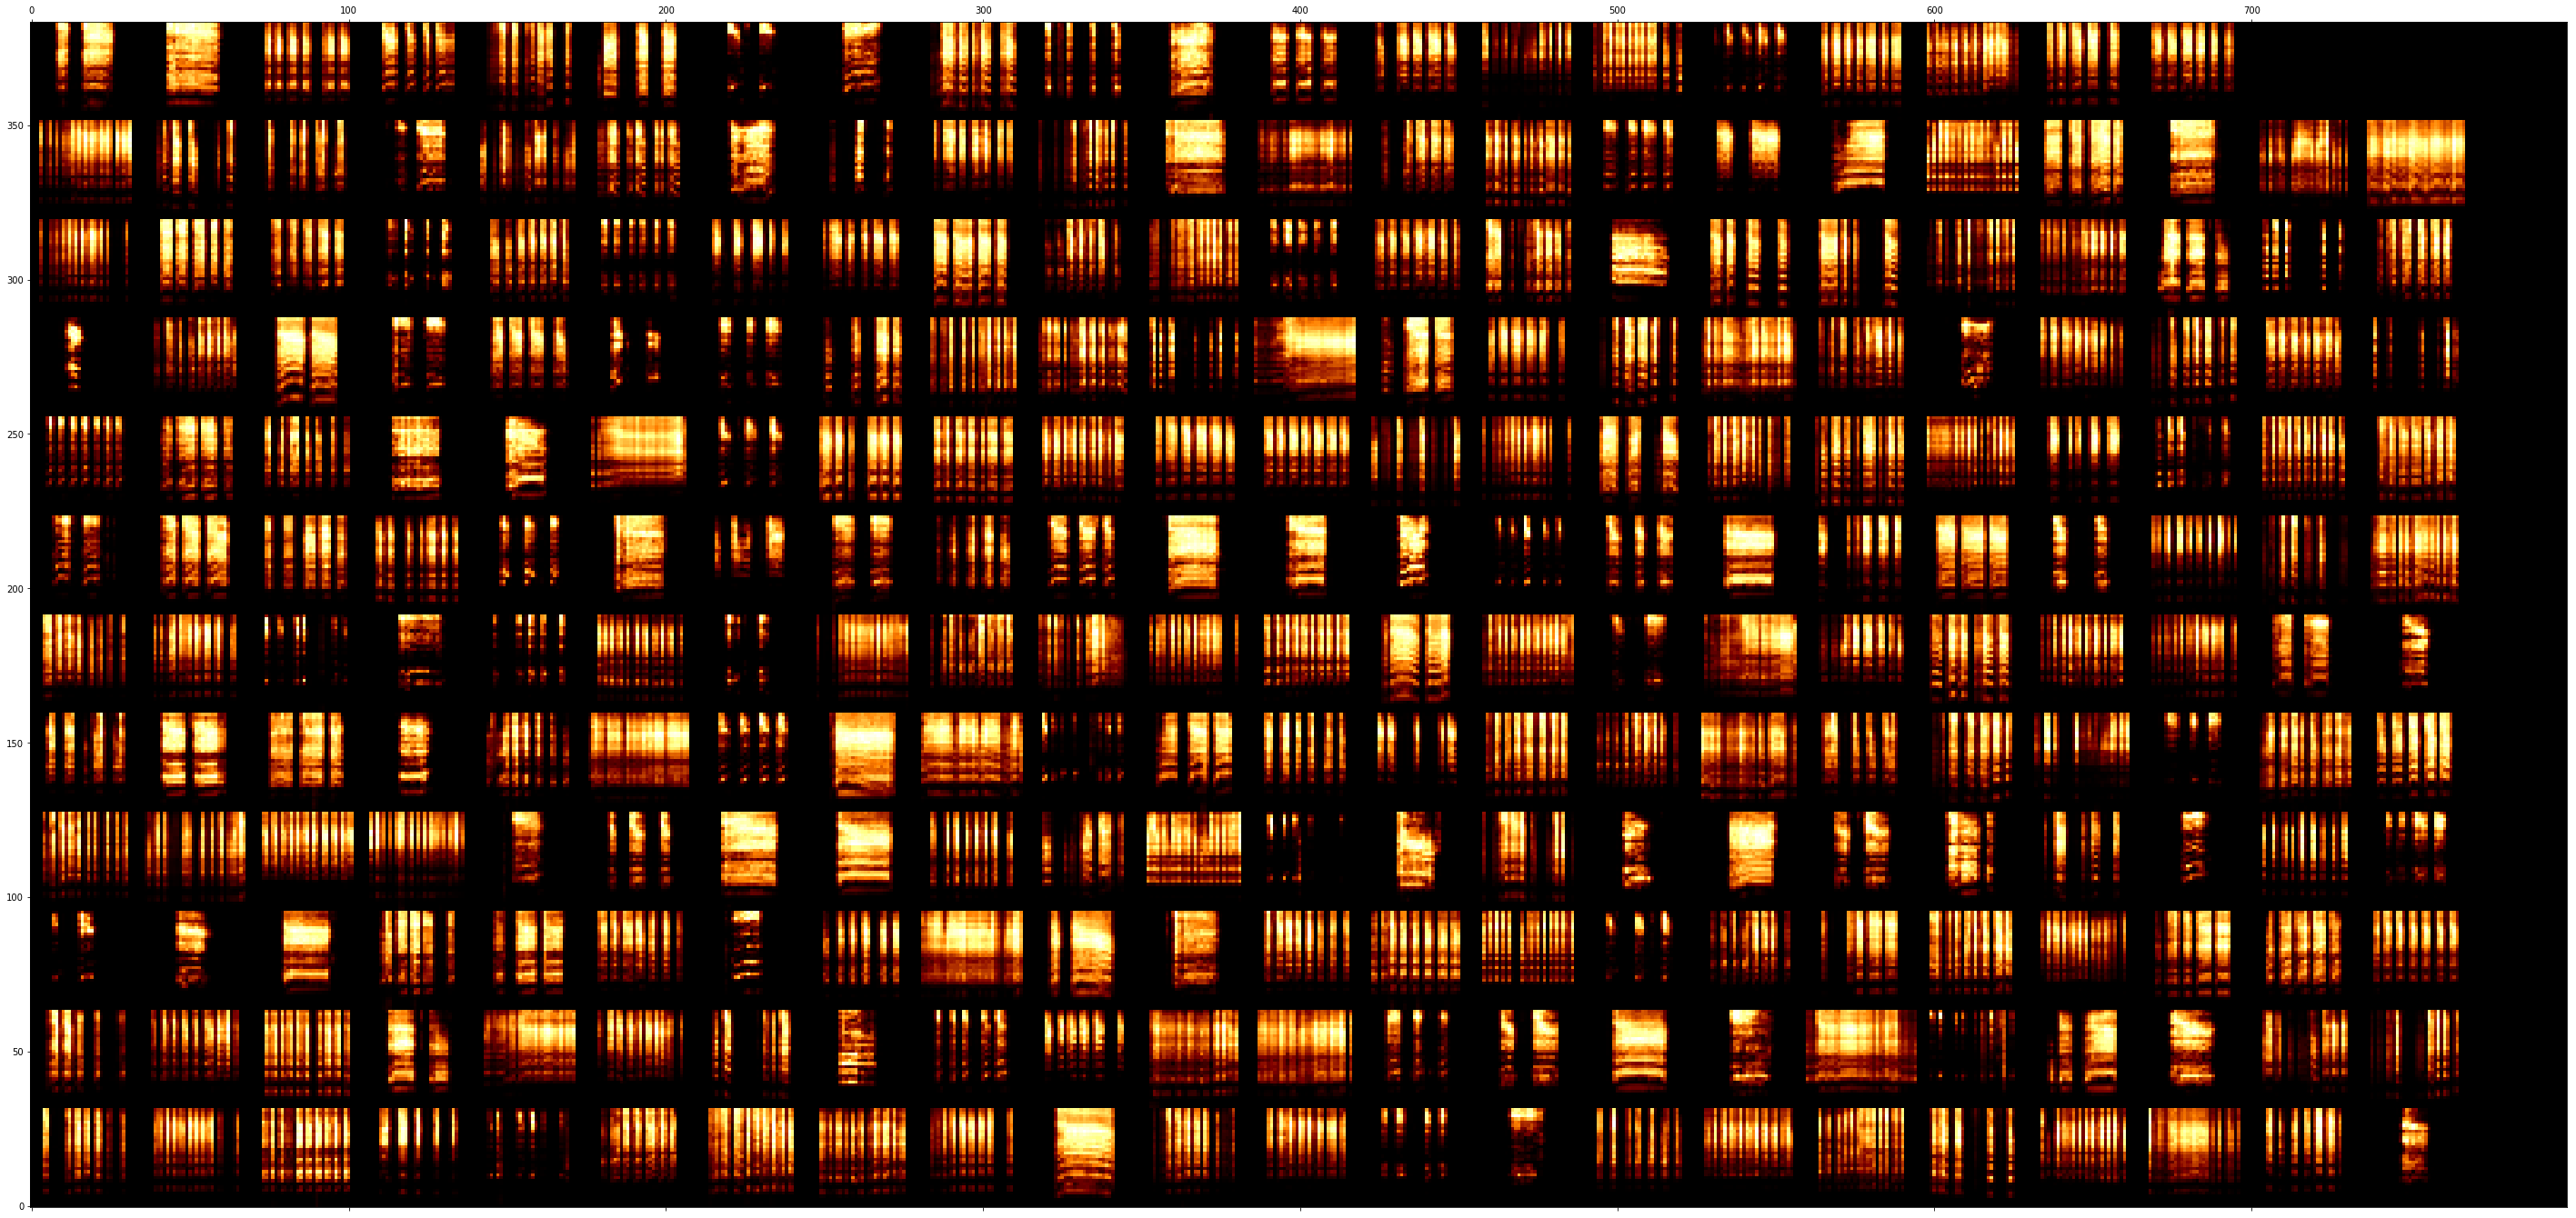

DC 585
(50.0, 32) (512, 800) 25.0 32 800


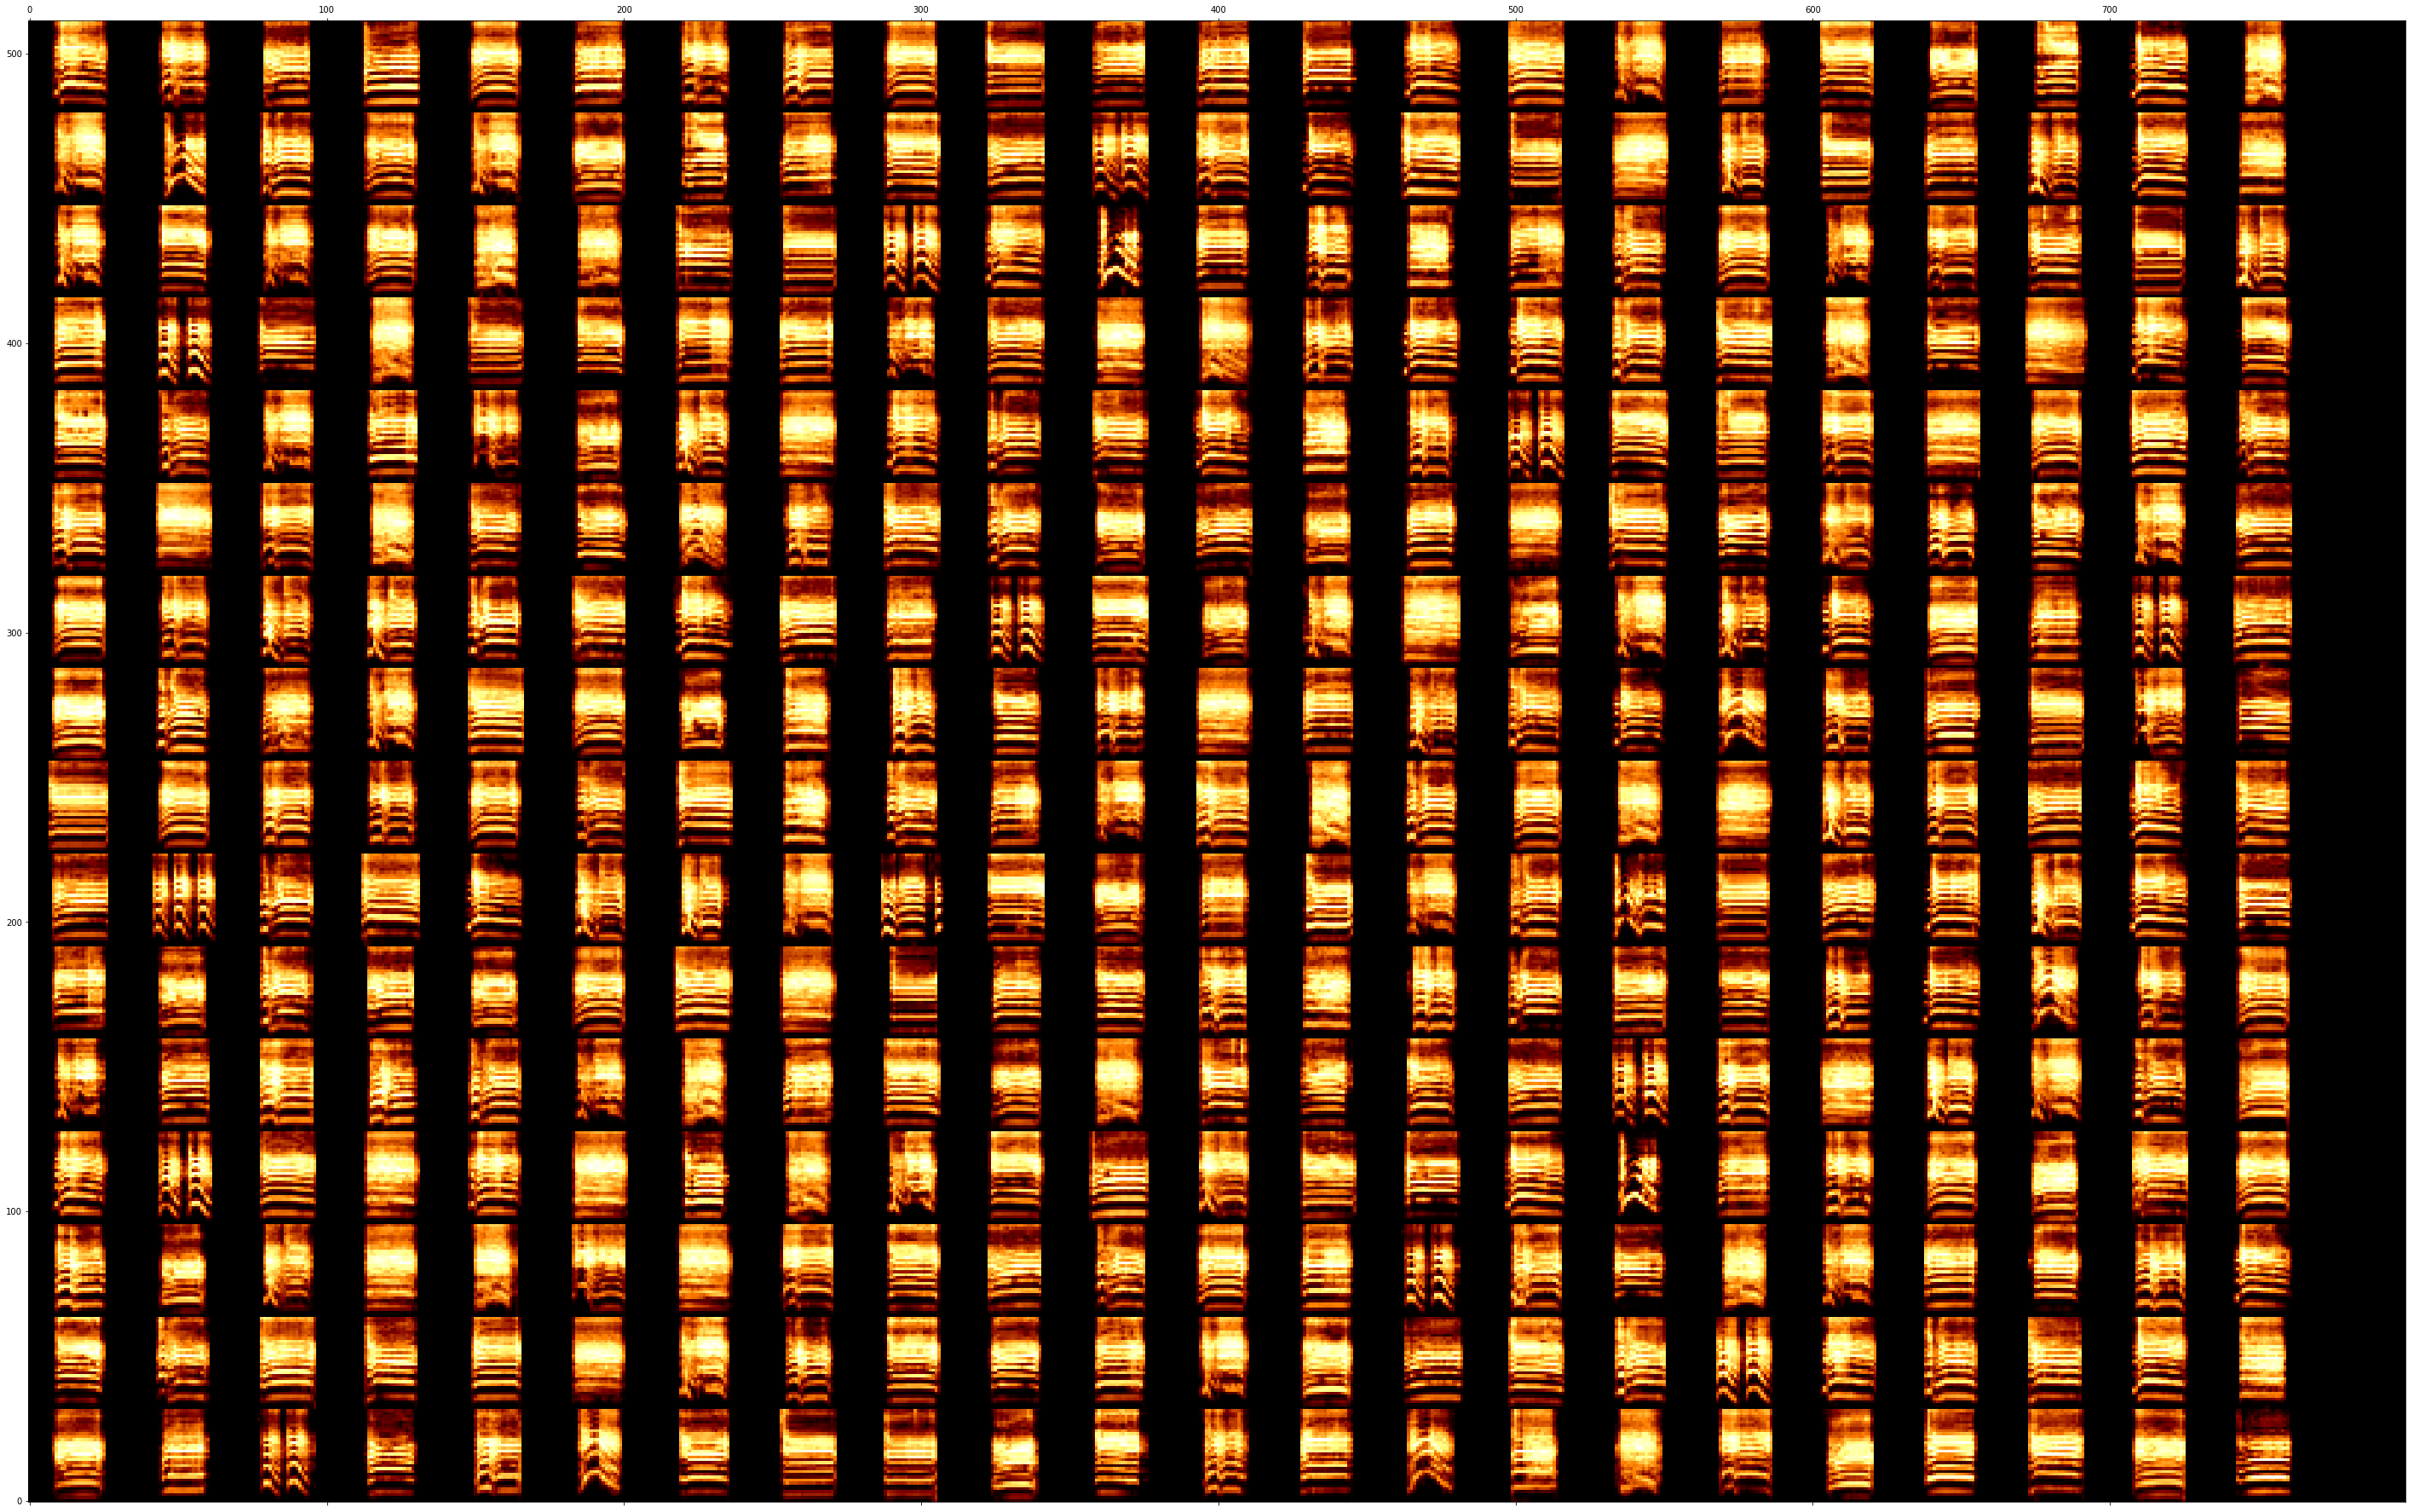

Di 16
(50.0, 2) (32, 800) 25.0 32 800


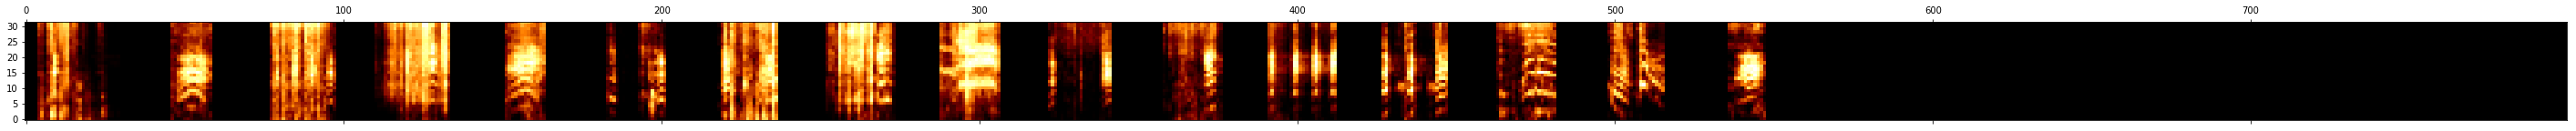

LT 215
(50.0, 20) (320, 800) 25.0 32 800


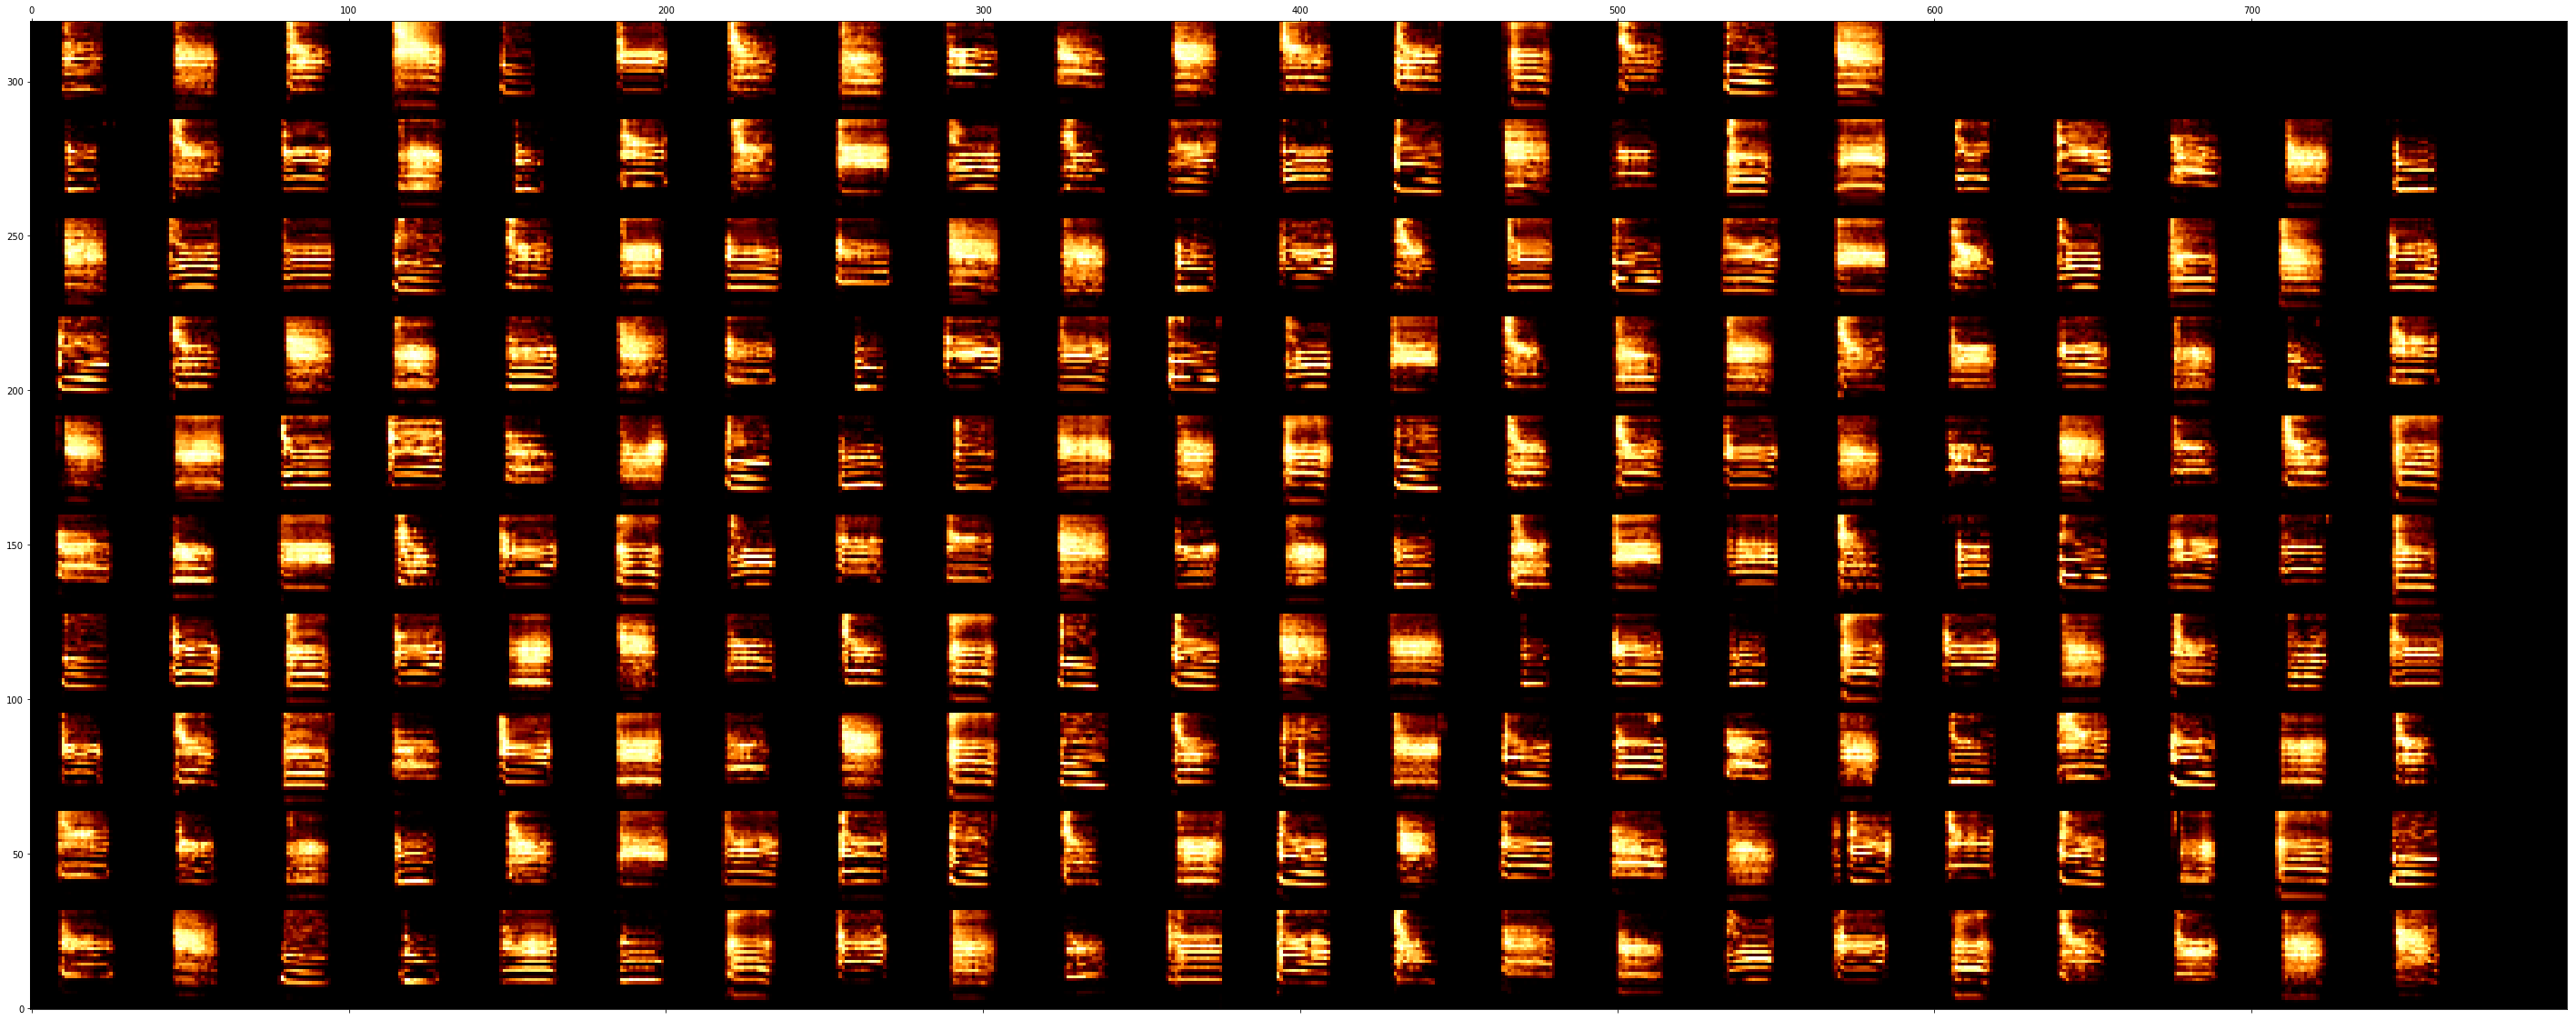

Ne 575
(50.0, 32) (512, 800) 25.0 32 800


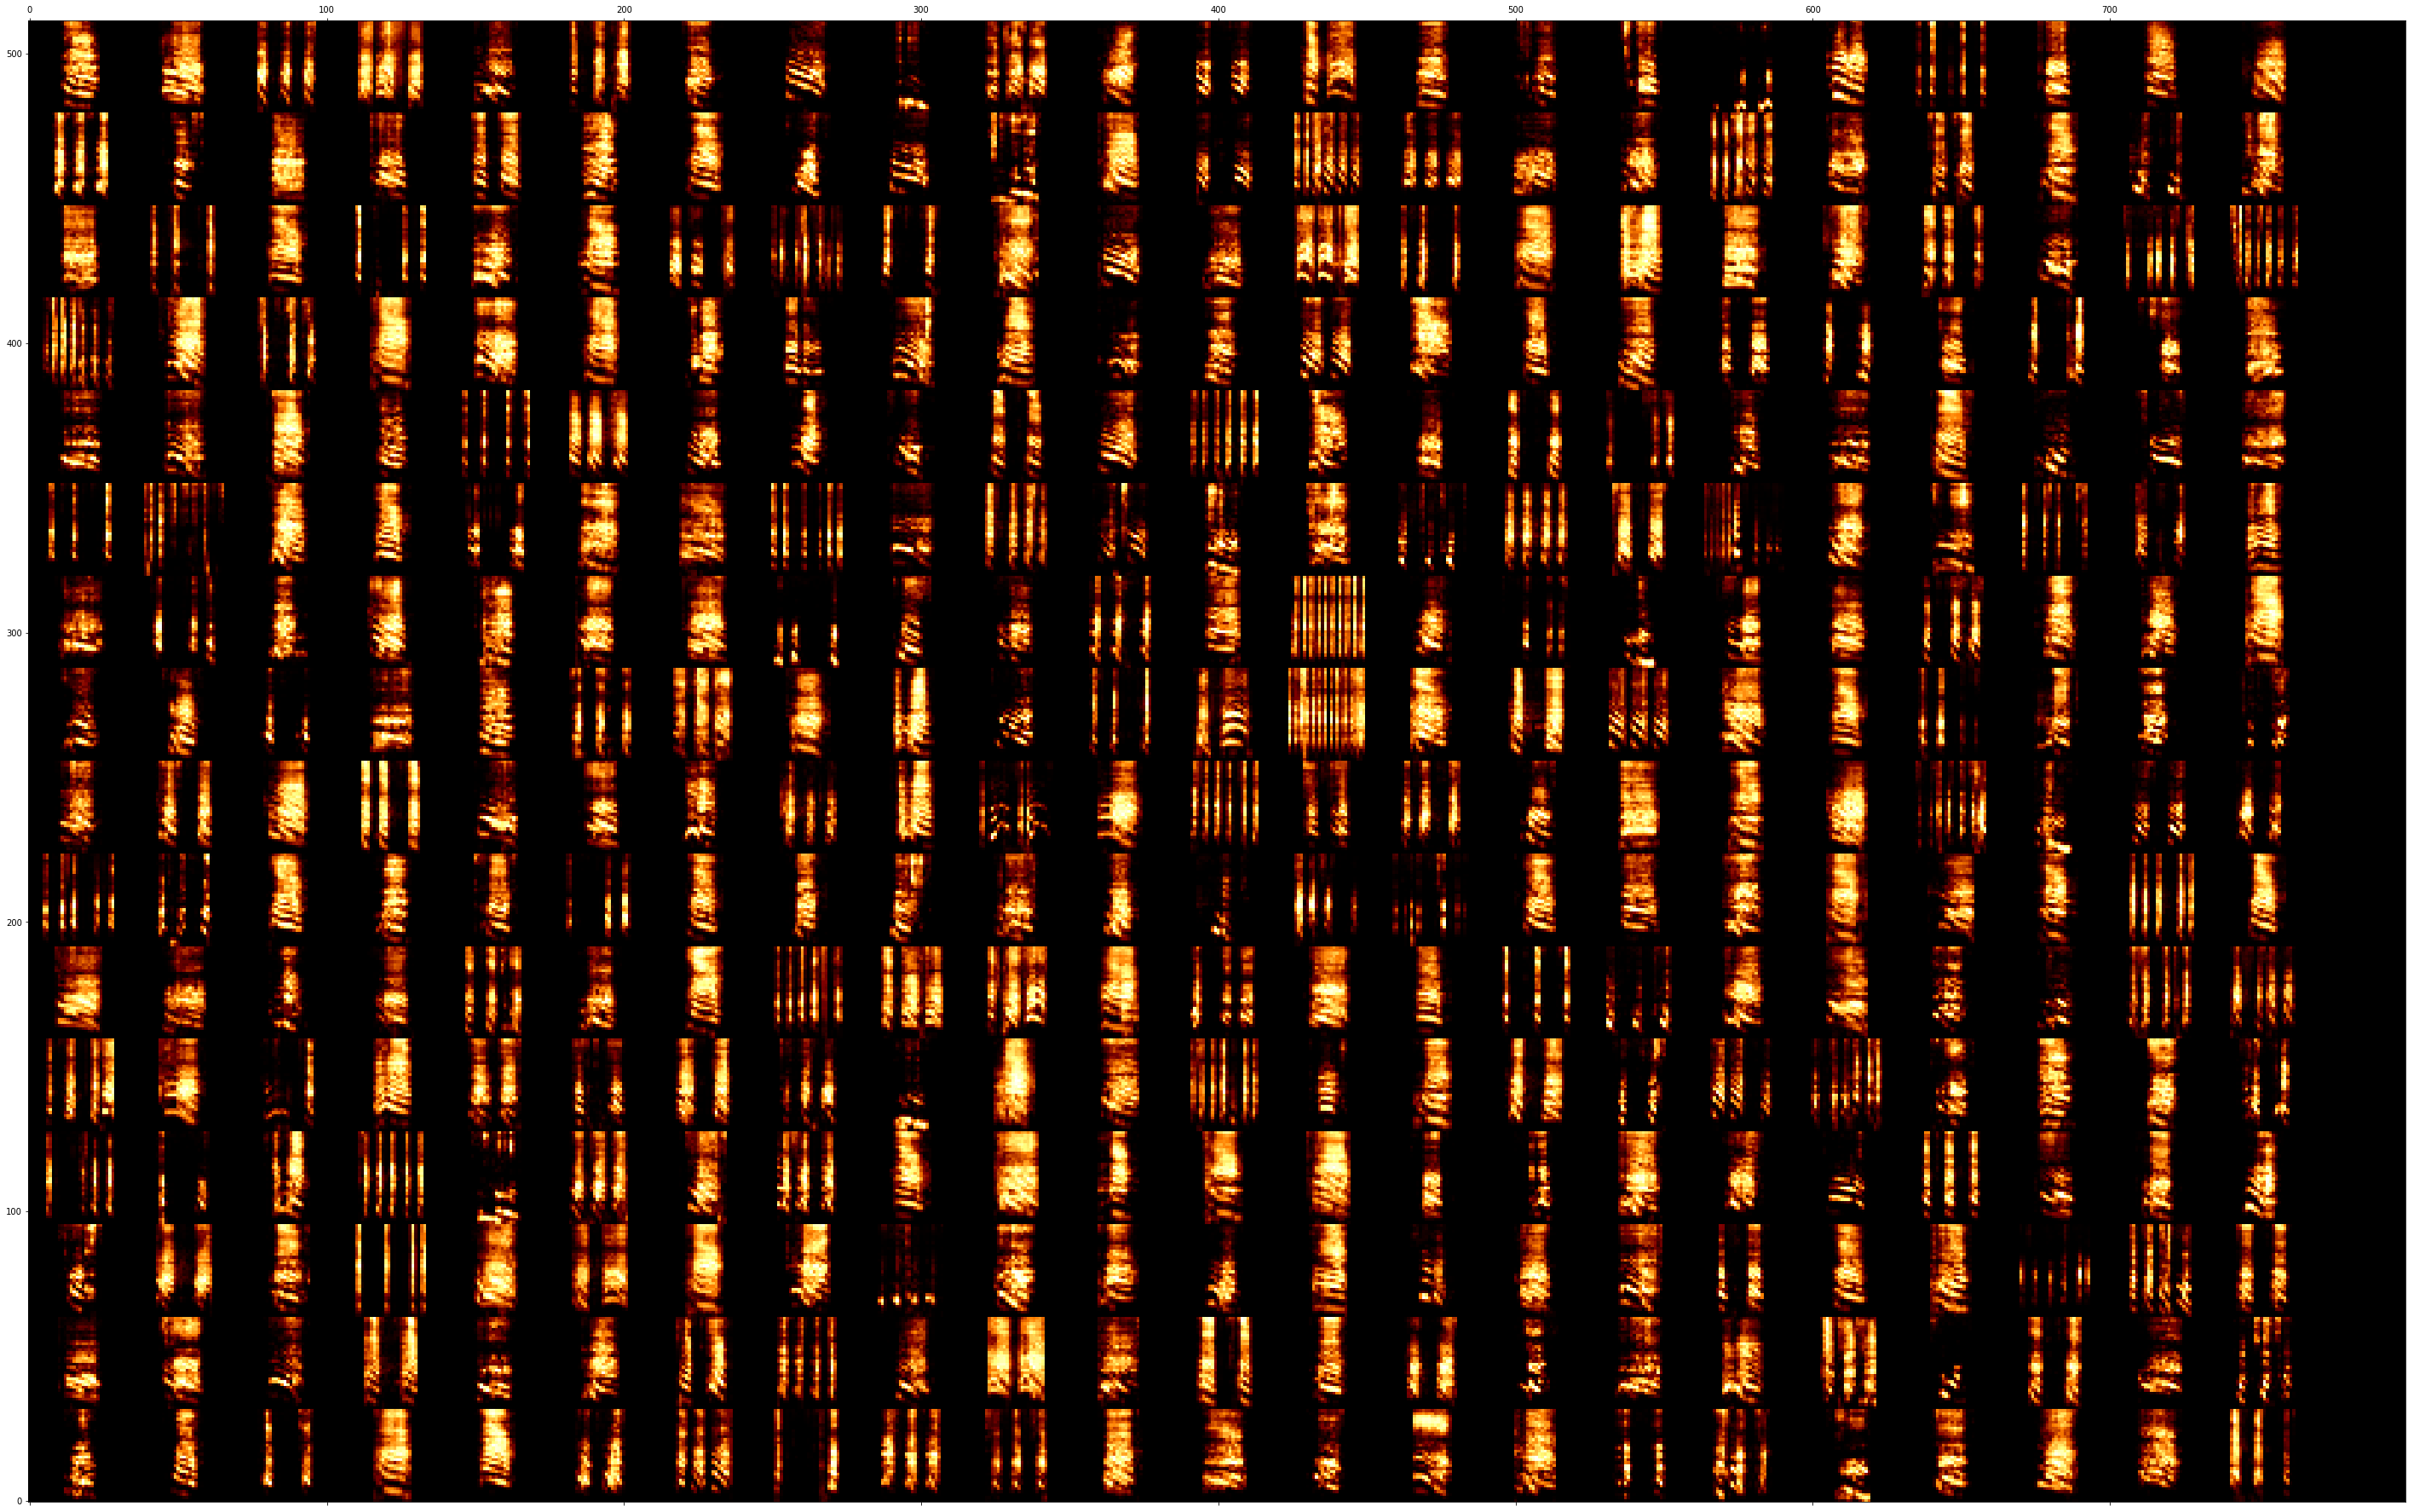

So 192
(50.0, 18) (288, 800) 25.0 32 800


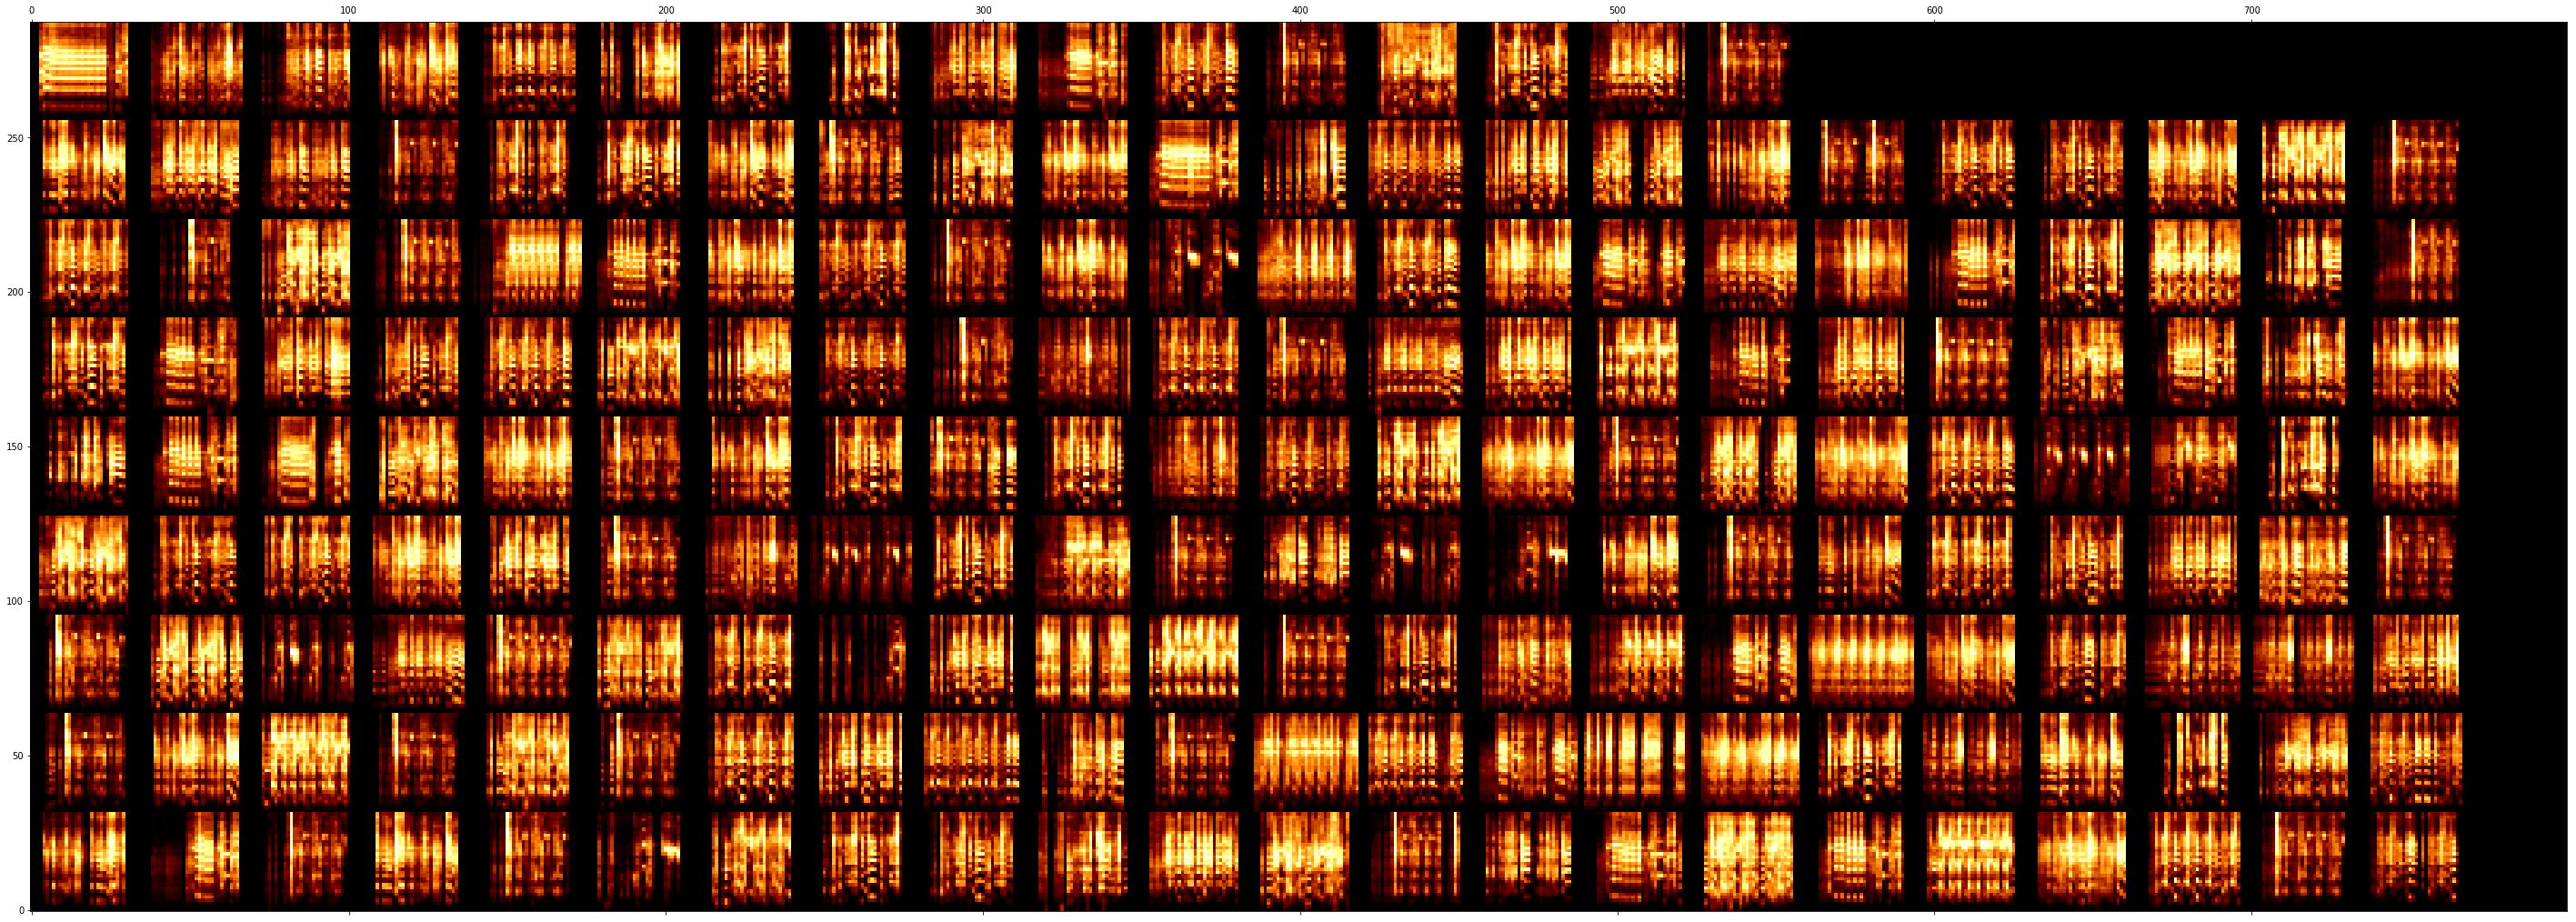

Te 613
(50.0, 32) (512, 800) 25.0 32 800


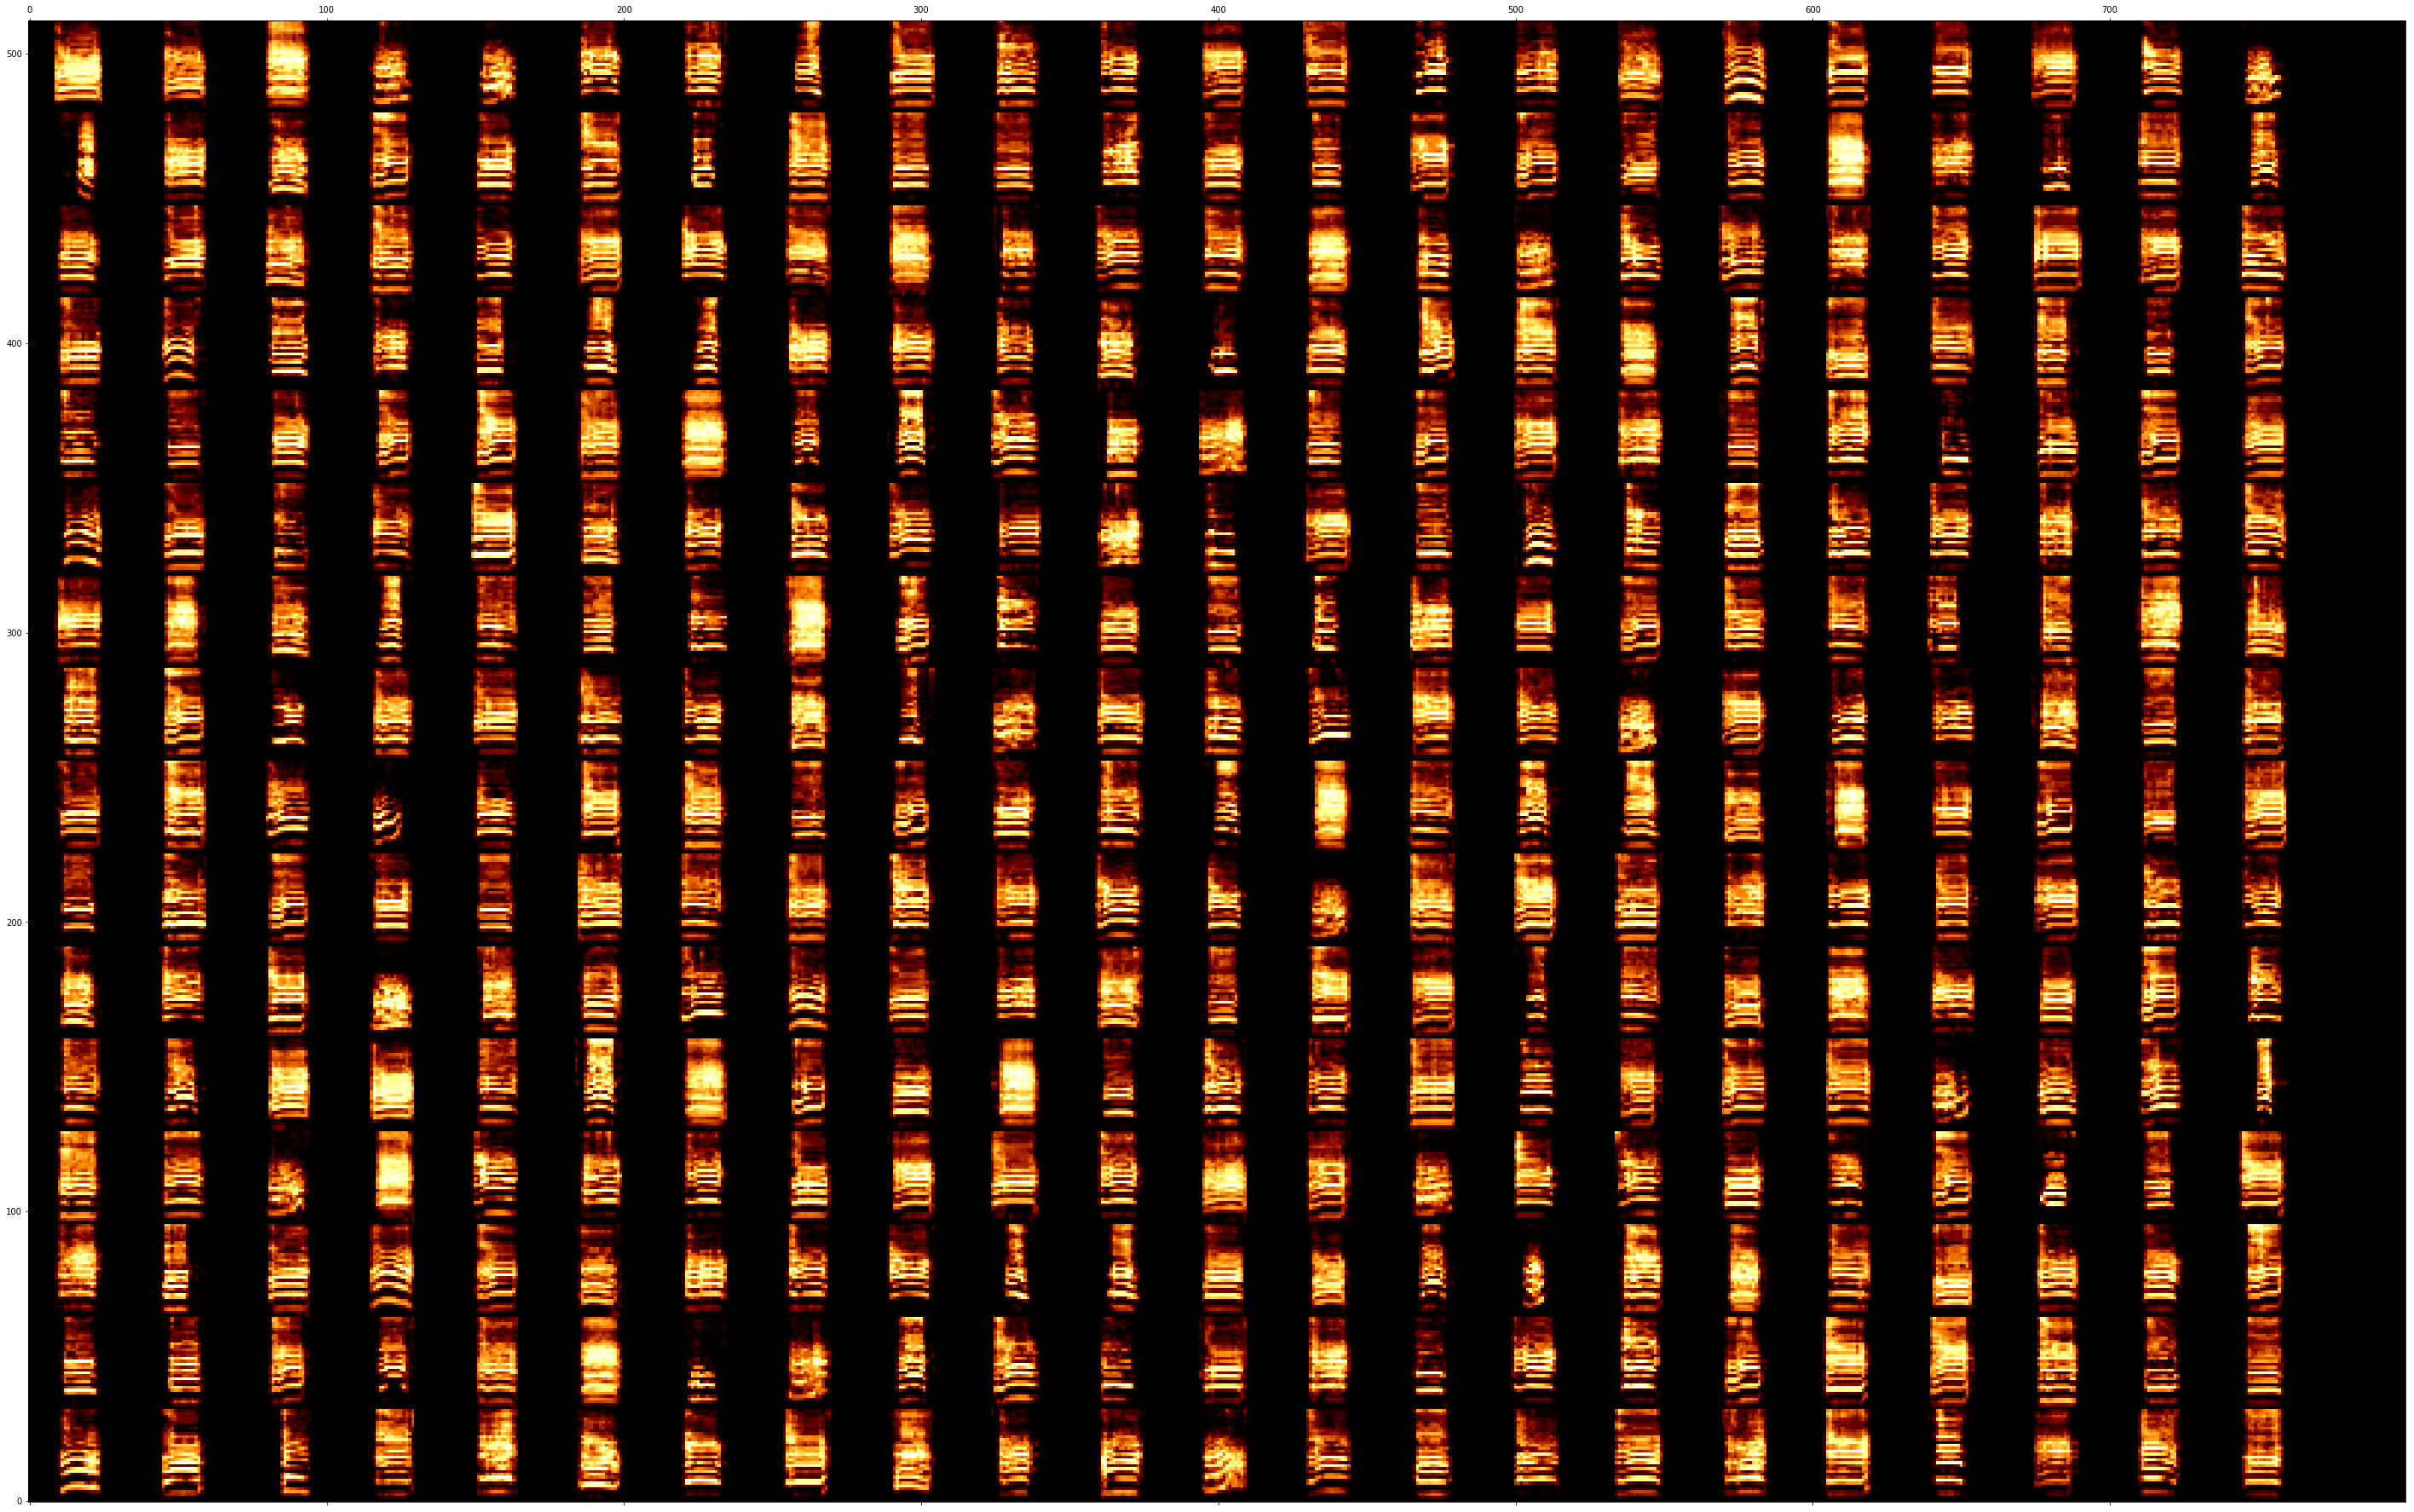

Th 279
(50.0, 26) (416, 800) 25.0 32 800


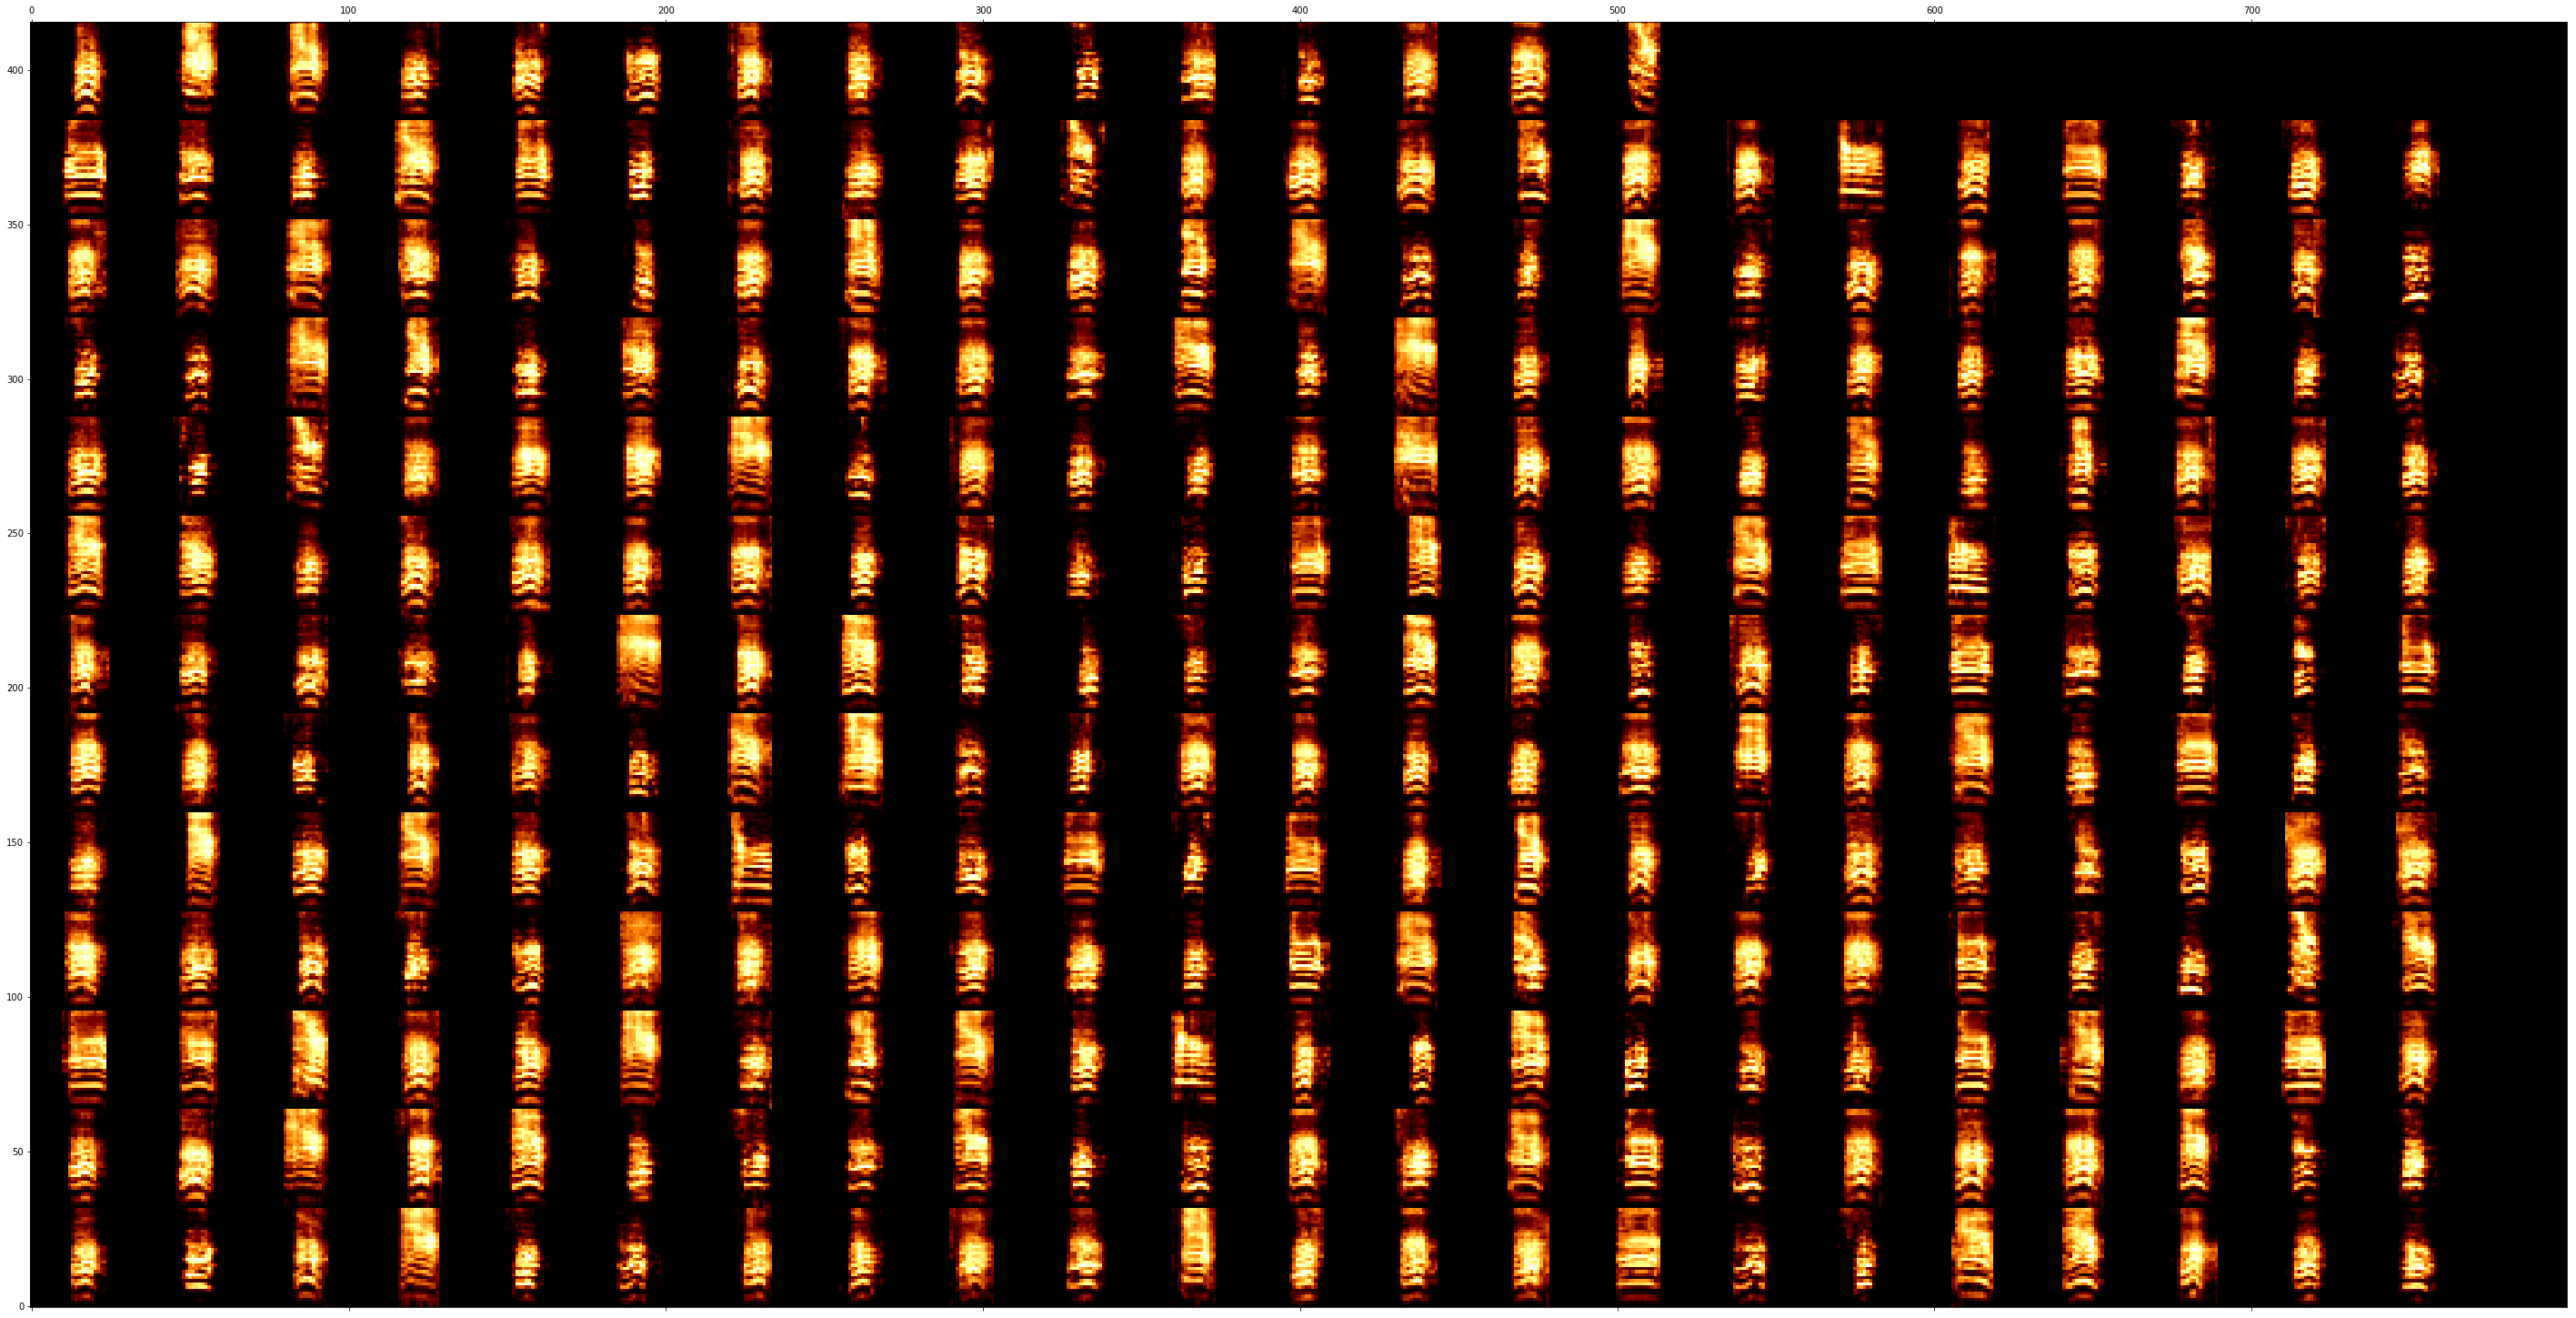

Tu 240
(50.0, 22) (352, 800) 25.0 32 800


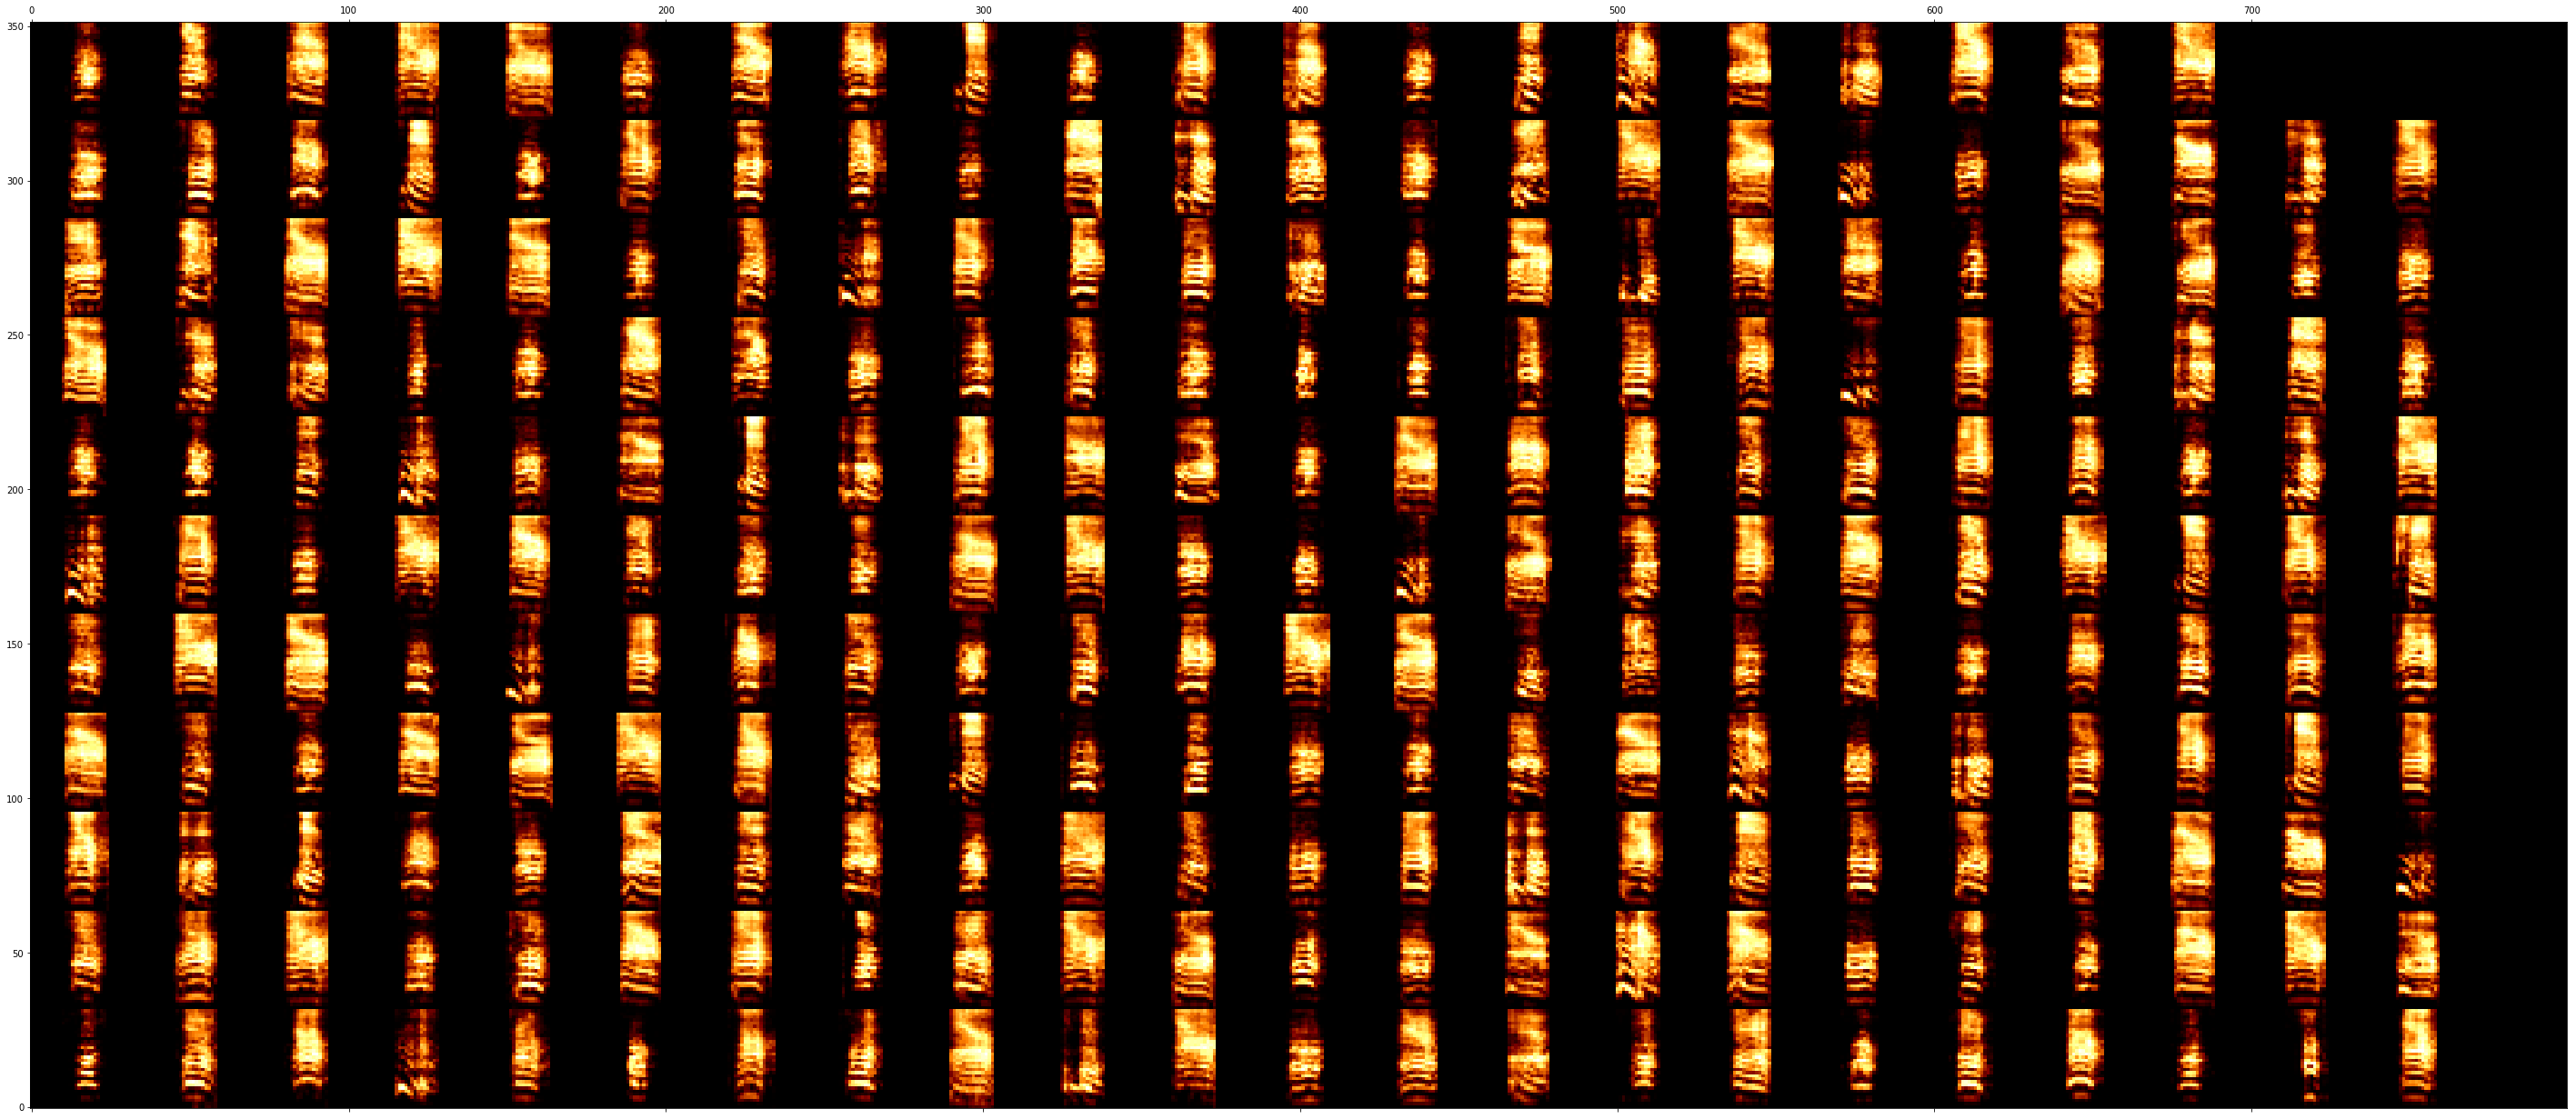

WC 3
(50.0, 2) (32, 800) 25.0 32 800


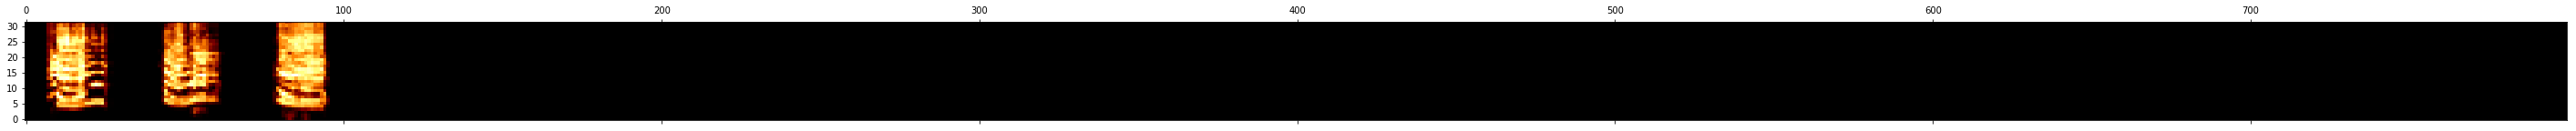

Wh 172
(50.0, 16) (256, 800) 25.0 32 800


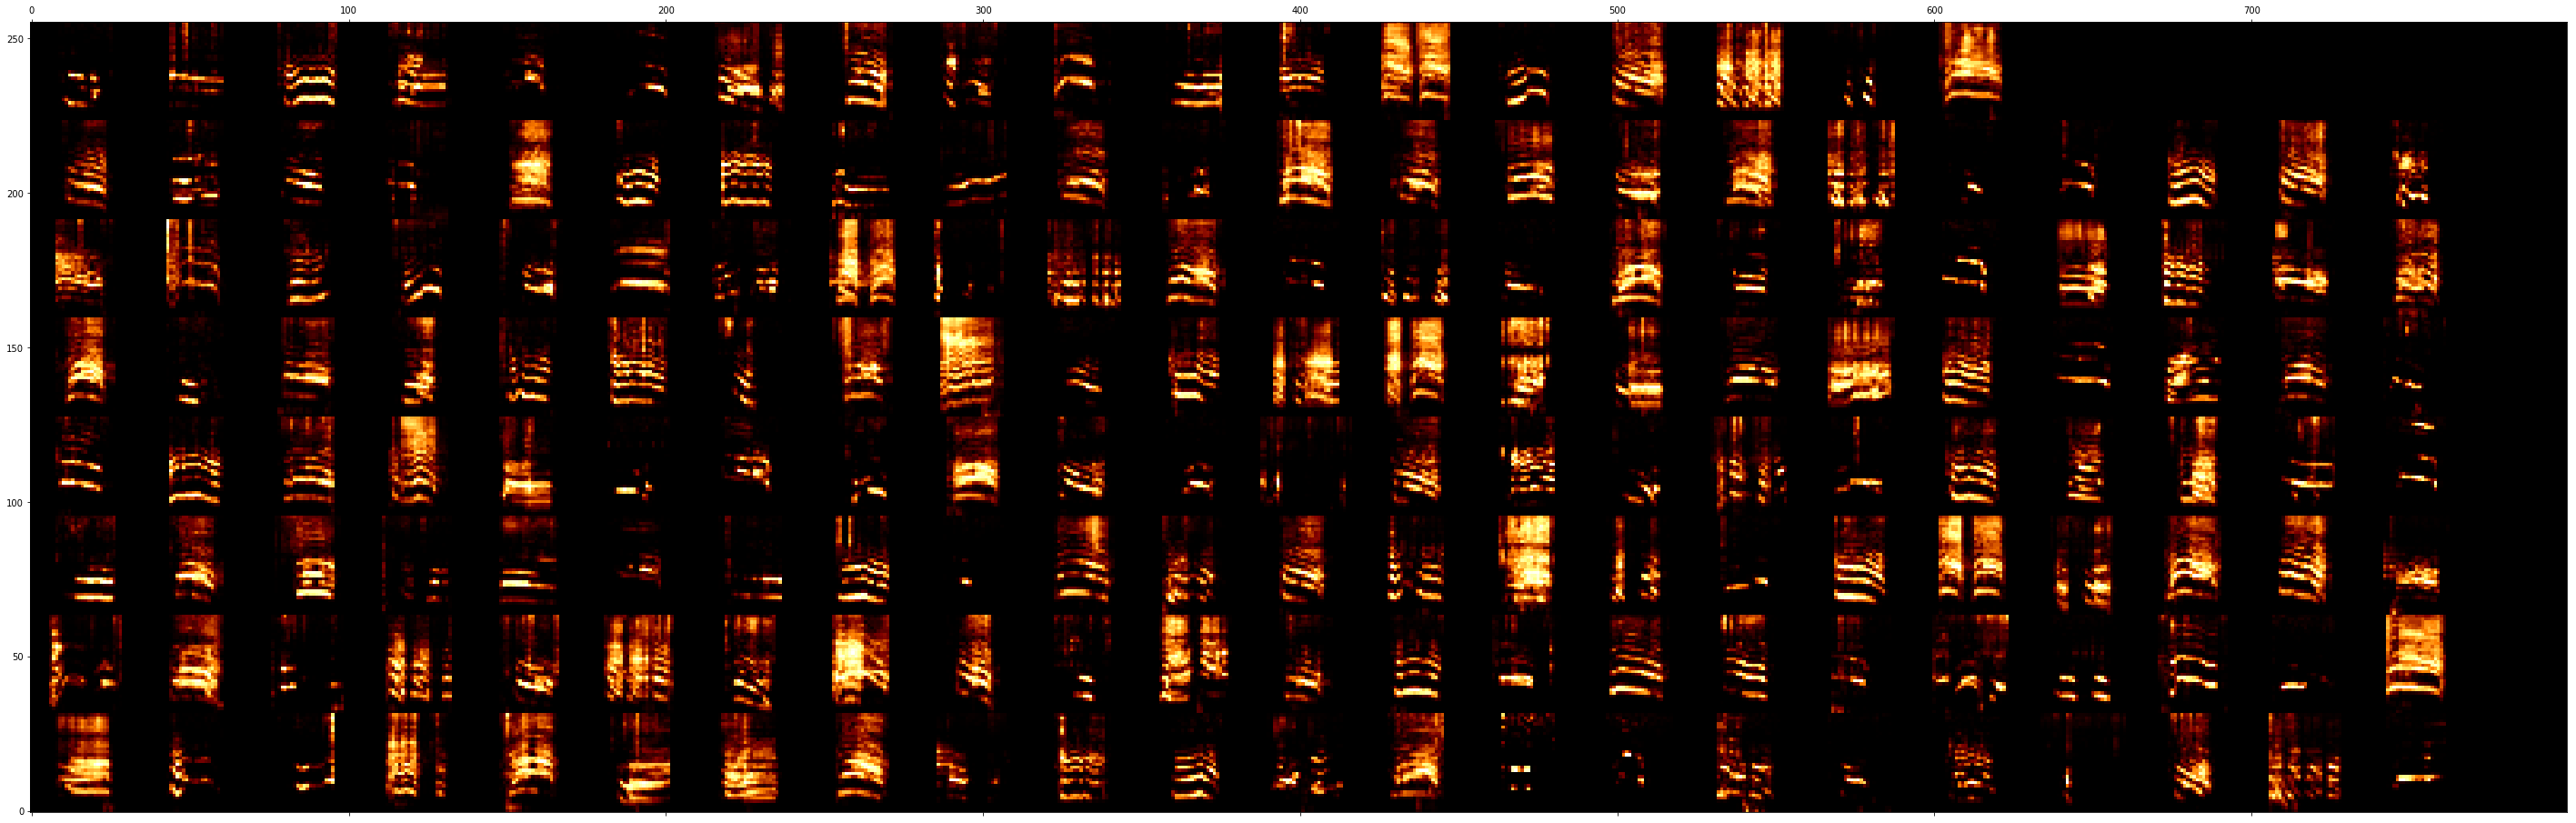

In [36]:
for vocalization_type in np.sort(syllable_df.vocalization_type.unique()):
    print(vocalization_type, np.sum(syllable_df.vocalization_type == vocalization_type))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.vocalization_type == vocalization_type].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [38]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'zf_library.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)